# Azure VM Reliability Simulator

## 1. Create synthetic data with LLM Scenarios
## 2. Explore the data
## 3. Perform feature engineering 
## 4. Use Gradient Boosting to create a model with Time Series Split
## 5. Survival Analysis with Time_Varying Covariates
## 6. Streamlit Dashboard

## 1. Generate synthetic data
- Use a failure effect of 20%

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Initialize GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium') 
model = GPT2LMHeadModel.from_pretrained('gpt2-medium') 

# Generate failure scenario using GPT-2
def generate_llm_failure_scenario():
    """Generate failure scenario using GPT-2"""
    prompt = "Azure VM failure scenario involving:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=100, do_sample=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Convert LLM description to telemetry signature
def scenario_to_pattern(scenario: str):
    """Convert LLM description to telemetry signature"""
    pattern = {
        'cpu_util': np.random.normal(40, 5),
        'mem_util': np.random.normal(50, 5),
        'disk_io': np.random.exponential(80),
        'net_latency': np.random.gamma(2, 10)
    }
    
    # Pattern adjustments based on keywords
    if 'CPU' in scenario or 'compute' in scenario:
        pattern['cpu_util'] = min(100, pattern['cpu_util'] * 1.8)
    if 'memory' in scenario or 'RAM' in scenario:
        pattern['mem_util'] = min(100, pattern['mem_util'] * 1.7)
    if 'disk' in scenario or 'storage' in scenario:
        pattern['disk_io'] = pattern['disk_io'] * 3.5
    if 'network' in scenario or 'latency' in scenario:
        pattern['net_latency'] = pattern['net_latency'] * 4.0
        
    return pattern

# Generate synthetic data
def generate_azure_vm_data(num_vms=1000, days=90):
    np.random.seed(42)
    vm_ids = [f"vm_{i:04d}" for i in range(num_vms)]
    dates = [datetime.now() - timedelta(days=x) for x in range(days)]
    
    # Pre-generate failure scenarios
    failure_scenarios = [generate_llm_failure_scenario() for _ in range(20)]
    failure_history = {vm: [] for vm in vm_ids}  # Track failure clusters

    data = []
    for vm_id in vm_ids:
        sys_failures = 0
        for i, date in enumerate(dates):
            # Apply failure history decay (temporal dependency)
            cluster_effect = 0.8 ** sys_failures

            is_failure = False
            if np.random.random() < (0.20 * cluster_effect):  # Failure event
                scenario = np.random.choice(failure_scenarios)
                pattern = scenario_to_pattern(scenario)
                sys_failures += 1
                is_failure = True
                failure_history[vm_id].append((date, scenario))
            else:
                # Baseline with failure history influence
                stress_factor = 1 + (0.3 * cluster_effect)
                pattern = {
                    'cpu_util': min(100, np.random.normal(40, 10) * stress_factor),
                    'mem_util': min(100, np.random.normal(50, 10) * stress_factor),
                    'disk_io': np.random.exponential(100) * stress_factor,
                    'net_latency': np.random.gamma(2, 15) * stress_factor
                }
                
            data.append({
                "vm_id": vm_id,
                "timestamp": date,
                "sys_failures": 1 if is_failure else 0,
                "cumulative_failures" : sys_failures,
                **pattern
            })
            
            # Decay failure counter weekly
            if i % 7 == 0:
                sys_failures = max(0, sys_failures - 1)
                
    return pd.DataFrame(data), failure_history

# Generate data
df_2, failure_history = generate_azure_vm_data()
df_2.to_csv("azure_vm_telemetry_2.csv", index=False)

/Users/AndreaLopera/.global-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sett

## 2. Explore the data

In [2]:
import pandas as pd
df = pd.read_csv("azure_vm_telemetry_2.csv")

count_of_zeros = (df['sys_failures'] == 0).sum()
print(f"Number of rows with 'sys_failures' == 0: {count_of_zeros}")

count_of_ones =(df['sys_failures'] == 1).sum()
print(f"Number of rows with 'sys_failures' == 1: {count_of_ones}")

Number of rows with 'sys_failures' == 0: 76699
Number of rows with 'sys_failures' == 1: 13301


In [3]:
df.head()

,vm_id,timestamp,sys_failures,cumulative_failures,cpu_util,mem_util,disk_io,net_latency
0,vm_0000,2025-08-07 21:24:29.420328,0,0,37.545558,69.145728,22.047518,90.669431
1,vm_0000,2025-08-06 21:24:29.420336,0,0,61.976651,58.896833,26.088269,48.161382
2,vm_0000,2025-08-05 21:24:29.420338,0,0,18.036863,77.354806,44.748989,13.089225
3,vm_0000,2025-08-04 21:24:29.420339,0,0,56.085215,84.053434,28.955662,27.141118
4,vm_0000,2025-08-03 21:24:29.420340,0,0,53.588849,58.299336,24.304963,19.603047


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vm_id                90000 non-null  object 
 1   timestamp            90000 non-null  object 
 2   sys_failures         90000 non-null  int64  
 3   cumulative_failures  90000 non-null  int64  
 4   cpu_util             90000 non-null  float64
 5   mem_util             90000 non-null  float64
 6   disk_io              90000 non-null  float64
 7   net_latency          90000 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.5+ MB


In [5]:
df.describe()

,sys_failures,cumulative_failures,cpu_util,mem_util,disk_io,net_latency
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,0.147789,1.659244,47.933001,60.107832,120.152296,35.595461
std,0.354893,1.248204,12.403269,12.854688,126.754682,27.569895
min,0.000000,0.000000,-2.037253,10.431630,0.002397,0.052025
25%,0.000000,1.000000,39.293945,50.795824,33.389011,16.116842
50%,0.000000,2.000000,46.878069,59.128032,80.937360,28.845980
75%,0.000000,2.000000,56.054249,68.603627,164.447663,47.657077
max,1.000000,7.000000,100.000000,100.000000,2788.040531,436.467357


## 3. Feature Engineering 

In [6]:
# # Feature engineering
## Sort data by VM and timestamp for accurate time-series calculations
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['vm_id', 'timestamp'])

## Time-Series features (Moving Averages)
### Set timestamp as index since when using groupby the time index is discarded
df_indexed = df.set_index('timestamp')
### Calculate the 7-day moving average for cpu_util
df_indexed['cpu_util_7d_avg'] = df_indexed.groupby('vm_id')['cpu_util'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
### Calculate the 7-day moving average for moving average for disk_io
df_indexed['disk_io_7d_avg'] = df_indexed.groupby('vm_id')['disk_io'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

# Convert the timestamp index back into a column
df = df_indexed.reset_index()

## Time-Based Features: features derived directly from the timestamp
df['hour'] = df['timestamp'].dt.hour
df['is_peak'] = df['hour'].between(8, 18).astype(int)

## Basic Interaction Features
df['cpu_mem_ratio'] = df['cpu_util'] / (df['mem_util'] + 1e-5)
df['cpu_disk_interaction'] = df['cpu_util'] * df['disk_io']

## Define Failure
df['failure'] = ((df['cpu_util'] > 90) & (df['disk_io'] > 250)).astype(int)

# Save this new dataframe for model training
df.to_csv('processed_vm_telemetry_2.csv', index=False)

In [7]:
df = pd.read_csv("processed_vm_telemetry_2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             90000 non-null  object 
 1   vm_id                 90000 non-null  object 
 2   sys_failures          90000 non-null  int64  
 3   cumulative_failures   90000 non-null  int64  
 4   cpu_util              90000 non-null  float64
 5   mem_util              90000 non-null  float64
 6   disk_io               90000 non-null  float64
 7   net_latency           90000 non-null  float64
 8   cpu_util_7d_avg       90000 non-null  float64
 9   disk_io_7d_avg        90000 non-null  float64
 10  hour                  90000 non-null  int64  
 11  is_peak               90000 non-null  int64  
 12  cpu_mem_ratio         90000 non-null  float64
 13  cpu_disk_interaction  90000 non-null  float64
 14  failure               90000 non-null  int64  
dtypes: float64(8), int6

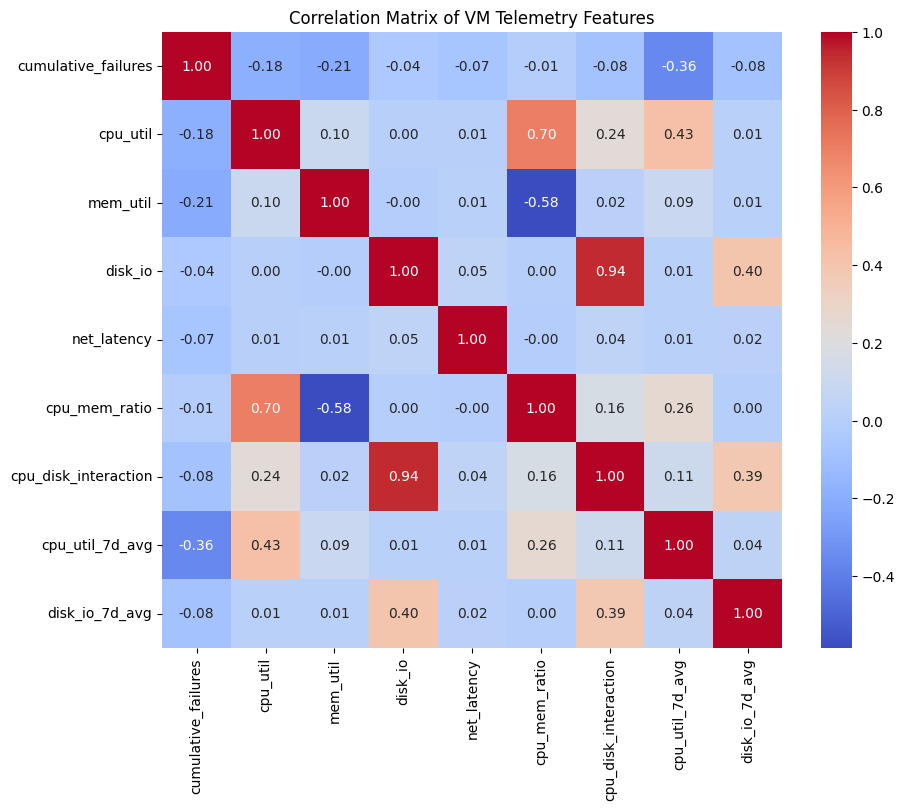

In [8]:
# Find out if independent numerical variables are correlated
import seaborn as sns
import matplotlib.pyplot as plt
numerical_variables = df[['cumulative_failures', 'cpu_util', 'mem_util',
       'disk_io', 'net_latency', 'cpu_mem_ratio',
       'cpu_disk_interaction', 'cpu_util_7d_avg', 'disk_io_7d_avg']]

correlation_matrix = numerical_variables.corr()

# Plot a headmap
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of VM Telemetry Features')
plt.show()

### 2. Gradient Boosting

In [9]:
# Divide independent features and dependent feature
X_model_2 = df[['cumulative_failures',
       'mem_util', 'net_latency', 'cpu_util_7d_avg',
       'disk_io_7d_avg', 'hour', 'is_peak', 'cpu_mem_ratio',
       'cpu_disk_interaction']]
y_model_2 = df['failure']

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt

# Get a list of unique VM IDs
vm_ids = df['vm_id'].unique()

# Store accuracies for each VM
vm_accuracies = {}

# Iterate over each VM 
for vm_id in vm_ids:
    print(f'Processing VM: {vm_id}')

    # Filter data for the current VM
    vm_data = df[df['vm_id'] == vm_id]
    X_vm = vm_data[X_model_2.columns]
    y_vm = vm_data['failure']

    # Check if there is enough data to split
    if len(X_vm) < 4:
        print(f'Skipping {vm_id} due to insufficient data.')
    
    # Apply TimeSeriesSplit to the single VM's data
    tss = TimeSeriesSplit(n_splits=3)
    fold_accuracies = []

    for train_index, test_index in tss.split(X_vm):
        X_train, X_test = X_vm.iloc[train_index], X_vm.iloc[test_index]
        y_train, y_test = y_vm.iloc[train_index], y_vm.iloc[test_index] 

        # Train and evaluate the model for this fold
        model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        fold_accuracies.append(acc)

    # Store the average accuracy for this VM 
    vm_accuracies[vm_id] = np.mean(fold_accuracies)

# Print and average the final results 
print("\n---Results---")
for vm_id, acc in vm_accuracies.items():
    print(f"VM {vm_id} Average Accuracy: {acc:.4f}")

Processing VM: vm_0000
Processing VM: vm_0001
Processing VM: vm_0002
Processing VM: vm_0003
Processing VM: vm_0004
Processing VM: vm_0005
Processing VM: vm_0006
Processing VM: vm_0007
Processing VM: vm_0008
Processing VM: vm_0009
Processing VM: vm_0010
Processing VM: vm_0011
Processing VM: vm_0012
Processing VM: vm_0013
Processing VM: vm_0014
Processing VM: vm_0015
Processing VM: vm_0016
Processing VM: vm_0017
Processing VM: vm_0018
Processing VM: vm_0019
Processing VM: vm_0020
Processing VM: vm_0021
Processing VM: vm_0022
Processing VM: vm_0023
Processing VM: vm_0024
Processing VM: vm_0025
Processing VM: vm_0026
Processing VM: vm_0027
Processing VM: vm_0028
Processing VM: vm_0029
Processing VM: vm_0030
Processing VM: vm_0031
Processing VM: vm_0032
Processing VM: vm_0033
Processing VM: vm_0034
Processing VM: vm_0035
Processing VM: vm_0036
Processing VM: vm_0037
Processing VM: vm_0038
Processing VM: vm_0039
Processing VM: vm_0040
Processing VM: vm_0041
Processing VM: vm_0042
Processing 

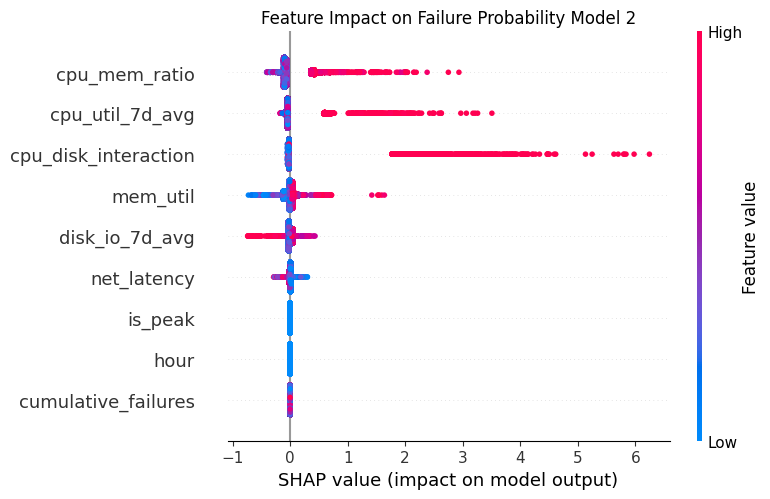

In [12]:
# Train the final model on the entire dataset
model_2 = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)

# X and y should be the full feature set and target variable for ALL VMs
model_2.fit(X_model_2, y_model_2)

# Now use this final model for the SHAP explanation
explainer_2 = shap.Explainer(model_2, X_model_2)
shap_values_2 = explainer_2(X_model_2)

# Visualize feature impacts 
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_2, show=False)
plt.title("Feature Impact on Failure Probability Model 2")
plt.tight_layout()
plt.savefig('feature_impact_2.png')

## Model Interpretability
### Instead of just knowing what percentage the model is accurate, let's analyze why the model made a particular decision for a specific data point "model's thought process."

- Using the data from the last split: The data that our final model instance was evaluated on

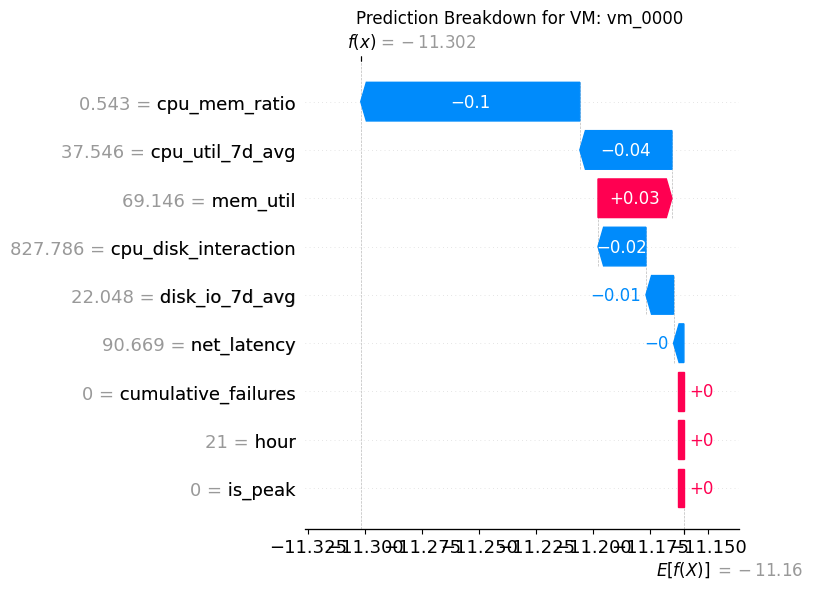

In [13]:
# Waterfall plot for specific VM (e.g., first in test set)
# Reset index to ensure we have access to the original data
X_test = X_test.reset_index(drop=False)

# Get VM ID for the first sample
vm_id = df.loc[X_test.index[0], 'vm_id']

# Plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_2[0], show=False)
plt.title(f"Prediction Breakdown for VM: {vm_id} ")
plt.tight_layout()
plt.savefig('shap_waterfall_2.png')

## Survival Analysis

In [14]:
from lifelines import CoxTimeVaryingFitter
from sklearn.preprocessing import StandardScaler

# Prepare survival data
df = df.sort_values(['vm_id', 'timestamp'])
df['start'] = df.groupby('vm_id')['timestamp'].rank(method='first').astype(int) - 1
df['end'] = df['start'] + 1  # Daily intervals
df['event'] = df['failure']

# CTV model
ctv = CoxTimeVaryingFitter(penalizer=0.1)
# 3. Feature engineering
survival_features = ['cumulative_failures',
       'mem_util', 'net_latency', 'cpu_util_7d_avg',
       'disk_io_7d_avg', 'cpu_mem_ratio',
       'cpu_disk_interaction']  

# 4. Outlier handling and scaling
scaler = StandardScaler()
for col in survival_features:
    q1, q99 = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], q1, q99).fillna(df[col].mean())

df[survival_features] = scaler.fit_transform(df[survival_features])

# 5. Model fitting
ctv_2 = CoxTimeVaryingFitter(penalizer=0.1)
ctv_2.fit(
    df[['vm_id', 'start', 'end', 'event'] + survival_features],
    id_col='vm_id',
    event_col='event',
    start_col='start',
    stop_col='end',
    show_progress=True
)

# 6. Results
print(ctv_2.summary)
ctv_2.plot()
plt.tight_layout()
plt.savefig('survival_plot_2.png', dpi=300)

Iteration 1: norm_delta = 4.42e-03, step_size = 0.9500, log_lik = -55.26104, newton_decrement = 9.75e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.21e-04, step_size = 0.9500, log_lik = -55.16377, newton_decrement = 2.44e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.10e-05, step_size = 0.9500, log_lik = -55.16353, newton_decrement = 6.09e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.81e-07, step_size = 1.0000, log_lik = -55.16353, newton_decrement = 1.52e-09, seconds_since_start = 0.0
Convergence completed after 4 iterations.
                          coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                             
cumulative_failures  -0.000959   0.999041  0.010537       -0.021612   
mem_util              0.000941   1.000941  0.010536       -0.019709   
net_latency          -0.000280   0.999720  0.010536       -0.020931   
cpu_util_7d_avg       0.002016   1.002018  0.010536       -0.018635   
disk

In [15]:
from lifelines.utils import concordance_index
c_index_2 = concordance_index(
    event_times=df['end'],
    event_observed=df['event'],
    predicted_scores=-ctv_2.predict_partial_hazard(df)
)
print(f"Concordance Index: {c_index_2:.3f}")

Concordance Index: 0.999


In [16]:
print("\nDescriptive statistics for survival features:")
print(df[survival_features].describe())


Descriptive statistics for survival features:
       cumulative_failures      mem_util   net_latency  cpu_util_7d_avg  \
count         9.000000e+04  9.000000e+04  9.000000e+04     9.000000e+04   
mean          6.126457e-17 -4.705372e-16  1.428980e-16     1.421717e-15   
std           1.000006e+00  1.000006e+00  1.000006e+00     1.000006e+00   
min          -1.338835e+00 -2.148706e+00 -1.268332e+00    -2.237499e+00   
25%          -5.301427e-01 -7.362552e-01 -7.393789e-01    -6.950934e-01   
50%           2.785496e-01 -7.764505e-02 -2.481780e-01    -3.679375e-02   
75%           2.785496e-01  6.713428e-01  4.777178e-01     6.549889e-01   
max           2.704626e+00  2.560248e+00  3.654149e+00     2.663375e+00   

       disk_io_7d_avg  cpu_mem_ratio  cpu_disk_interaction  
count    9.000000e+04   9.000000e+04          9.000000e+04  
mean     7.686493e-16  -2.959805e-16         -1.167659e-16  
std      1.000006e+00   1.000006e+00          1.000006e+00  
min     -1.769704e+00  -1.895190e

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Get baseline survival
baseline_survival = ctv_2.baseline_survival_

# 2. Create reference individual (median values)
reference = df[survival_features].median().to_frame().T
reference_scaled = scaler.transform(reference)
reference_df = pd.DataFrame(reference_scaled, columns=survival_features)

# 3. Compute partial hazard for reference
partial_hazard_reference = np.exp(ctv_2.predict_partial_hazard(reference_df).values[0])

# 4. Create comparison individuals
comparisons = [
    {'cpu_util_7d_avg': 30},
    {'cpu_util_7d_avg': 60},
    {'cpu_util_7d_avg': 90}
]

plt.figure(figsize=(10, 6))

for i, values in enumerate(comparisons):
    # Create individual profile
    individual = reference.copy()
    for feature, value in values.items():
        individual[feature] = value
    
    # Scale features
    individual_scaled = scaler.transform(individual)
    individual_df = pd.DataFrame(individual_scaled, columns=survival_features)
    
    # Compute partial hazard
    partial_hazard = np.exp(ctv_2.predict_partial_hazard(individual_df).values[0])
    
    # Calculate relative risk
    relative_risk = partial_hazard / partial_hazard_reference
    
    # Compute survival curve
    survival_curve = baseline_survival ** relative_risk
    
    # Plot
    plt.plot(survival_curve, label=f"CPU Avg={values['cpu_util_7d_avg']}%")

plt.xlabel('Time (hours)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by CPU Utilization 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('survival_curves_cpu_2.png', dpi=300)

In [29]:
# Save artifacts for dashboard
import joblib
import shap
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
import pickle

# 1. Save Model (XGBoost)
joblib.dump(model_2, 'model.pkl')

# 2. Save Survival Model
with open('survival_model_1.pkl', 'wb') as file:
    pickle.dump(ctv_2, file)

# 3. Save SHAP Explainer
# - For Tree-based models
joblib.dump(explainer_2, 'shap_explainer_1.joblib')

# - For non-tree models (alternative)
with open('shap_explainer_1.pkl', 'wb') as f:
    pickle.dump(explainer_2, f)

# 4. Save Dataset
df.to_csv('vm_telemetry_2.csv')

# 5. Save Failure History
np.save('failure_history_2.npy', failure_history, allow_pickle=True)
# Alternative: joblib.dump(failure_history, 'failure_history.joblib')

# 6. Save Feature Names (Critical!)
with open('feature_names_2.txt', 'w') as f:
    f.write(','.join(X_train.columns.tolist()))